In [3]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 241.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 190.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Define the AlexNet architecture from scratch
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Original AlexNet was designed for 224x224 images
        # We'll adapt it for CIFAR-10's 32x32 images by using smaller filters and strides

        # Convolutional layers
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            #nn.Linear(256 * 4 * 4, 4096),
            nn.Linear(256 * 28 * 28, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("Feature shape:", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
# Data loading and preprocessing
def load_cifar10():
    transform_train = transforms.Compose([
        transforms.Resize(224),  # AlexNet expects 224x224 images
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),  # AlexNet expects 224x224 images
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

    return trainloader, testloader

In [23]:
# Training function
def train_model(model, trainloader, epochs=10, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()

    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        epoch_time = time.time() - start_time

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')

        scheduler.step()

    return train_losses, train_accs

In [24]:
# Evaluation function
def evaluate_model(model, testloader, device='cuda'):
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [25]:
# Set epochs and device
epochs=5
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [26]:
trainloader, testloader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [29]:
print("\nTraining custom AlexNet...")
custom_alexnet = AlexNet(num_classes=10)
custom_losses, custom_accs = train_model(custom_alexnet, trainloader, epochs=epochs, device=device)
custom_test_acc = evaluate_model(custom_alexnet, testloader, device=device)
print(f"Custom AlexNet Test Accuracy: {custom_test_acc:.2f}%")


Training custom AlexNet...
Epoch 1/5, Loss: 1.7248, Accuracy: 36.69%, Time: 167.61s
Epoch 2/5, Loss: 1.2508, Accuracy: 55.12%, Time: 164.27s
Epoch 3/5, Loss: 0.9192, Accuracy: 67.40%, Time: 163.96s
Epoch 4/5, Loss: 0.5814, Accuracy: 79.51%, Time: 163.57s
Epoch 5/5, Loss: 0.2652, Accuracy: 91.05%, Time: 163.28s
Custom AlexNet Test Accuracy: 73.29%


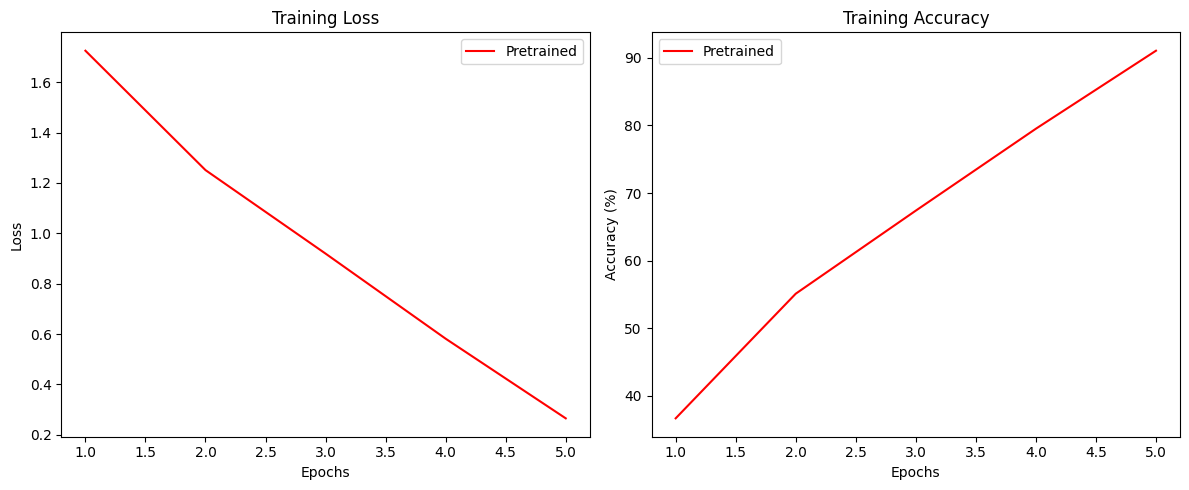

In [30]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), custom_losses, 'r-', label='Pretrained')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), custom_accs, 'r-', label='Pretrained')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()